In [1]:
%matplotlib inline
from scipy import misc
from glob import glob

vehicle_images = [misc.imread(x, mode='RGB') for x in glob('vehicles/*/*.png')]
non_vehicle_images = [misc.imread(x, mode='RGB') for x in glob('non-vehicles/*/*.png')]
print("Loaded", len(vehicle_images), "vehicle images and", len(non_vehicle_images), "non-vehicle images.")

Loaded 8792 vehicle images and 8968 non-vehicle images.


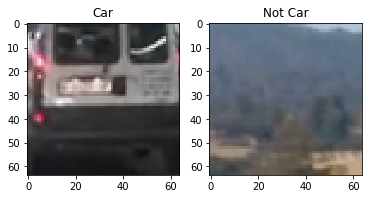

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.add_subplot(1,2,1).set_title("Car")
plt.imshow(vehicle_images[0])
fig.add_subplot(1,2,2).set_title("Not Car")
plt.imshow(non_vehicle_images[0])
fig.savefig("output_images/car_not_car.png")
plt.show()

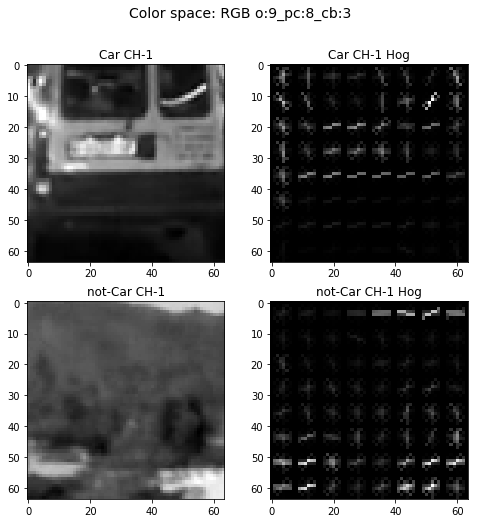

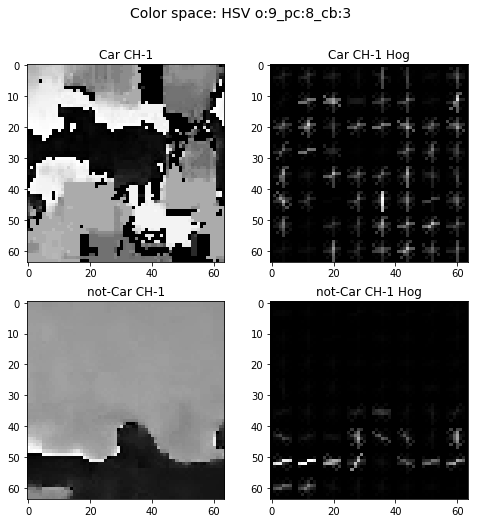

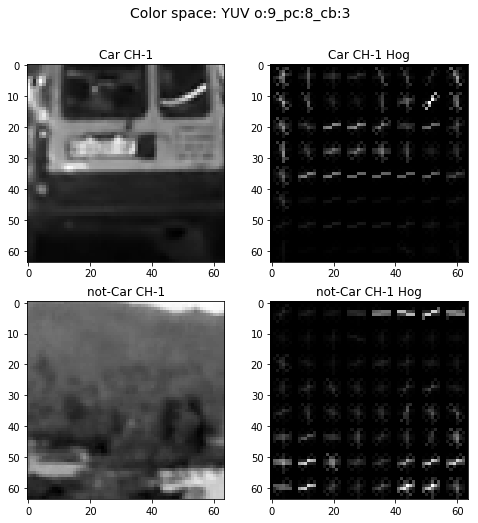

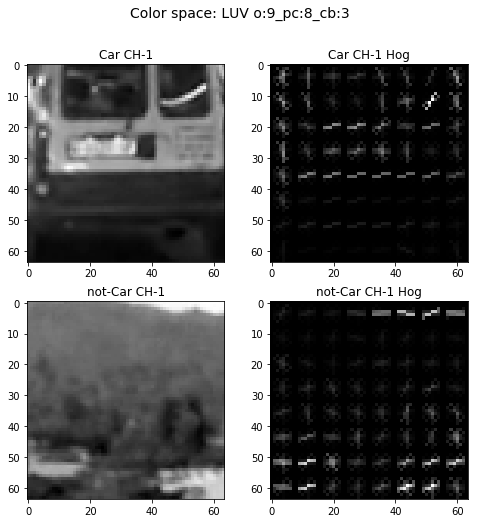

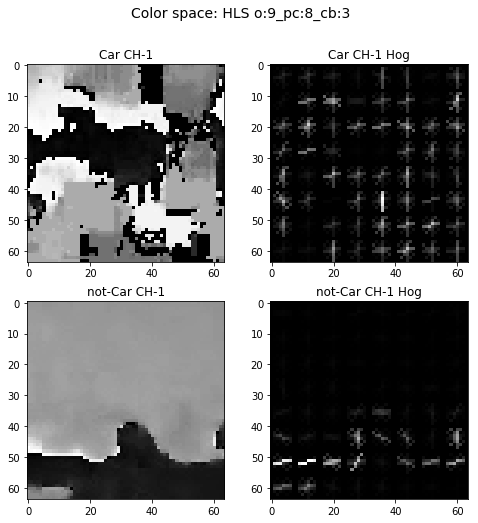

In [3]:
import cv2
import skimage
from skimage import feature, color
import numpy as np

def do_hog(image, orientations, pixels_per_cell, cells_per_block, visualise):
    ret = skimage.feature.hog(image, orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                       cells_per_block=(cells_per_block, cells_per_block), block_norm='L2-Hys', visualise=visualise,
                       transform_sqrt=False, feature_vector=True)
    if visualise:
        plt.imshow(ret[1], cmap='gray')
    else:
        return ret

def convert_image(image, colorspace):
    conversion = {'HSV': cv2.COLOR_RGB2HSV, 'YUV': cv2.COLOR_RGB2YUV, 'LUV': cv2.COLOR_RGB2LUV, 'HLS': cv2.COLOR_RGB2HLS}
    if colorspace in conversion:
        return cv2.cvtColor(image, conversion[colorspace])
    else:
        return np.copy(image)
    
for colorspace in ['RGB', 'HSV', 'YUV', 'LUV', 'HLS']:
    vehicle_image = convert_image(vehicle_images[0], colorspace)
    non_vehicle_image = convert_image(non_vehicle_images[0], colorspace)

    for orientations in [9]:
        for pixels_per_cell in [8]:
            for cells_per_block in [3]:
                description = "o:" + str(orientations) + "_pc:" + str(pixels_per_cell) + "_cb:" + str(cells_per_block)
                fig = plt.figure(figsize = (8,8))
                fig.suptitle("Color space: " + colorspace + " " + description, fontsize=14)
                image = vehicle_image[:,:,0]
                fig.add_subplot(2,2,1).set_title("Car CH-1")
                plt.imshow(image, cmap='gray')
                fig.add_subplot(2,2,2).set_title("Car CH-1 Hog")
                do_hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualise=True)

                image = non_vehicle_image[:,:,0]
                fig.add_subplot(2,2,3).set_title("not-Car CH-1")
                plt.imshow(image, cmap='gray')
                fig.add_subplot(2,2,4).set_title("not-Car CH-1 Hog")
                do_hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualise=True)

                fig.savefig("output_images/HOG_" + colorspace + "_" + description + ".png")


In [110]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return np.array(features, dtype='int64')

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the feature vector
    return hist_features

def extract_features(image):
    if image.shape != (64,64,3):
        image = cv2.resize(image, (64,64))
    image = convert_image(image, 'YUV')
    return np.concatenate((bin_spatial(image), color_hist(image), do_hog(image[:,:,0], orientations=9, pixels_per_cell=8, cells_per_block=3, visualise=False)))

print("We have:", len(extract_features(vehicle_images[0])), "features per image")


We have: 6084 features per image


In [111]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
X = [extract_features(x) for x in vehicle_images + non_vehicle_images]
X_scaler = StandardScaler().fit(X)
X = X_scaler.transform(X)

y = np.concatenate((np.ones(len(vehicle_images)),  np.zeros(len(non_vehicle_images)) ))

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
print("We have", len(X_train), "training examples with", X_train[0].shape, "features each, and", len(X_test),"test examples" )

We have 14208 training examples with (6084,) features each, and 3552 test examples


In [133]:
from sklearn import svm

# Comment out the search so we don't accidentally run it, since it takes ages to run


svr = svm.SVC(kernel='rbf', C=5)
#parameters = {'kernel':['linear', 'rbf'], 'C':[1, 5, 10]}
#clf = model_selection.GridSearchCV(svr, parameters, verbose=1)
clf = svr
clf.fit(X_train, y_train)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [135]:
print(clf.predict(X_test[0:3]))
print(y_test[0:3])

[ 1.  1.  0.]
[ 1.  1.  0.]


In [138]:
#print("Best parameters are:\t\t", clf.best_params_)
#print("Score on training data:\t\t", clf.best_score_)
print("Score on test data:\t\t", clf.score(X_test, y_test))

Score on test data:		 0.994087837838


In [139]:
# Load test images
test_images = [misc.imread(x, mode='RGB') for x in glob('test_images/*.jpg')]

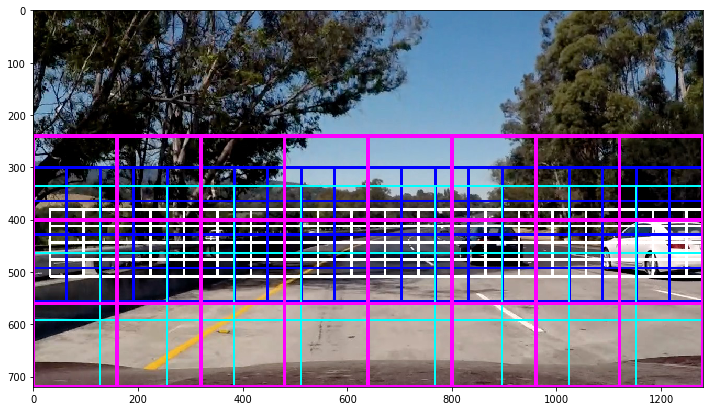

In [169]:
def draw_boxes(image, bboxes, color=(0, 0, 255), thick=6):
    image = np.copy(image)
    for bbox in bboxes:
        cv2.rectangle(image, bbox[0], bbox[1], color, thick)
    return image
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# Also takes a function, fun, that is an optimal
# functions that it will run against each window, passing it an image of the window.
# If it returns true, the window will be added to the list of windows to be returned
def slide_window(img, fun=None,  x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    w,h = xy_window
    for y in range(y_start_stop[0], y_start_stop[1] - h+1, int(h*(1 - xy_overlap[1]))):
        for x in range(x_start_stop[0], x_start_stop[1] - w+1, int(w*(1 - xy_overlap[0]))):
            if not fun or fun(img[y:(y+h), x:(x+w),:]):
                window_list.append(((x, y), (x+w, y+h)))
    # Return the list of windows
    return window_list

def get_windows(image, fun=None):
    windows = []
    windows.append(slide_window(image, fun, x_start_stop=[32, None], y_start_stop=[380, 380+64*2], 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5)))
    windows.append(slide_window(image, fun, x_start_stop=[None, None], y_start_stop=[300, 600], 
                        xy_window=(128, 128), xy_overlap=(0.5, 0.5)))    
    windows.append(slide_window(image, fun, x_start_stop=[None, None], y_start_stop=[test_images[0].shape[0]-int(256*1.5), None], 
                        xy_window=(256, 256), xy_overlap=(0.5, 0.5)))
    windows.append(slide_window(image, fun, x_start_stop=[None, None], y_start_stop=[test_images[0].shape[0]-int(320*1.5), None], 
                        xy_window=(320, 320), xy_overlap=(0.5, 0.5)))
    return windows

def draw_windows_on_rgb_image(image, fun=None):
    windows = get_windows(image, fun)
    window_img = np.copy(image)
    window_img = draw_boxes(window_img, windows[0], color=(255, 255, 255), thick=3)
    window_img = draw_boxes(window_img, windows[1], color=(0, 0, 255), thick=3)
    window_img = draw_boxes(window_img, windows[2], color=(0, 255, 255), thick=2)
    window_img = draw_boxes(window_img, windows[3], color=(255, 0, 255), thick=5)
    return window_img
    
plt.figure(figsize = (12,12))
window_img = draw_windows_on_rgb_image(test_images[0])
misc.imsave('output_images/sliding_windows.jpg', window_img)
plt.imshow(window_img)


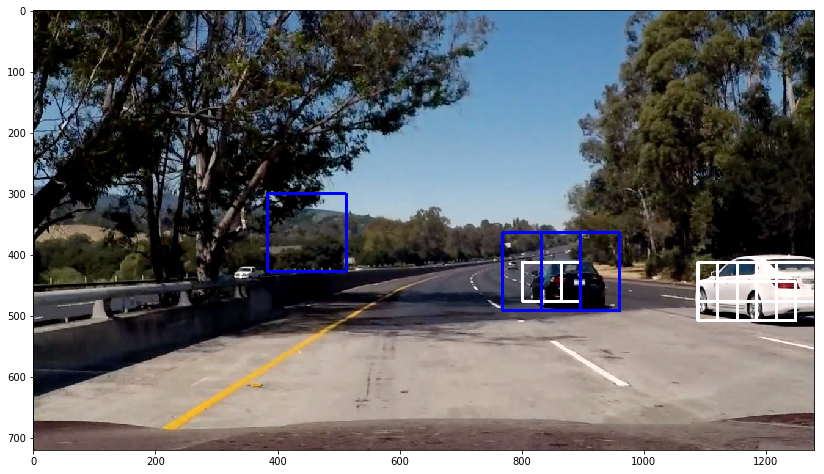

In [158]:
def predict_window(image):
    return clf.predict(X_scaler.transform([extract_features(image)])) == 1

def box_image(index, show=False):
    window_img = draw_windows_on_rgb_image(test_images[i], fun=predict_window)
    misc.imsave('output_images/sliding_window_' + str(i) + '.jpg', window_img)
    if show:
        plt.figure(figsize = (14,14))
        plt.imshow(window_img)

for i in range(len(test_images)):
    box_image(i, i == 0)

In [167]:
# Decrease memory usage
non_vehicle_images=None
vehicle_images=None
X=None
X_train=None
y_train=None
X_test=None
y_test=None

In [229]:
windows = get_windows(test_images[0], fun=predict_window)

In [212]:
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
